In [1]:
!kaggle datasets download -d msambare/fer2013

import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 73% 44.0M/60.3M [00:00<00:00, 243MB/s]
100% 60.3M/60.3M [00:00<00:00, 234MB/s]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


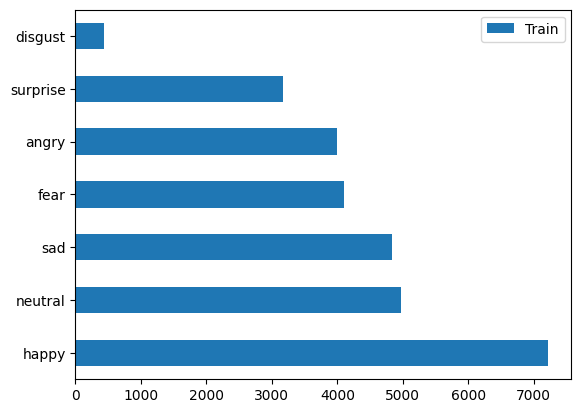

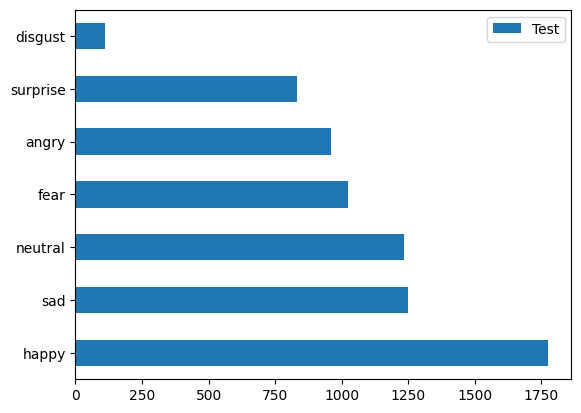

In [3]:
train_dir = "/content/train/"
test_dir = "/content/test/"

def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

pd.concat([Train_Count, Test_Count], axis=1)
Train_Count.plot(kind='barh')
Test_Count.plot(kind='barh')
plt.show()


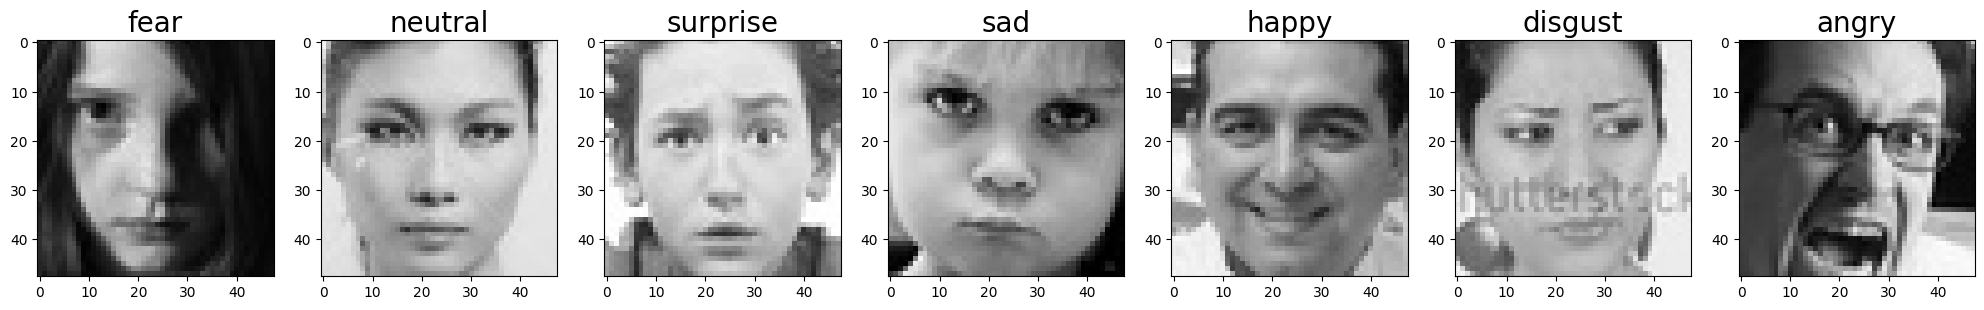

In [6]:
plt.figure(figsize=(25, 8))
image_count = 1
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)
plt.show()


In [7]:
img_shape = 48
batch_size = 64
train_data_path = '/content/train/'
test_data_path = '/content/test/'

train_preprocessor = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_preprocessor = ImageDataGenerator(
    rescale=1/255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
def Create_VGG19_Model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))
    base_model.trainable = True

    # Freeze all layers except the last few
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax')
    ])

    return model

VGG19_Model = Create_VGG19_Model()

VGG19_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                     

In [13]:
VGG19_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [14]:
checkpoint_path = "VGG19_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005, verbose=1)

callbacks = [Checkpoint, Early_Stopping, Reducing_LR]



In [15]:
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

VGG19_history = VGG19_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,
    batch_size=batch_size,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/30
448/448 [==============================] - 65s 126ms/step - loss: 2.1968 - accuracy: 0.1994 - val_loss: 1.9685 - val_accuracy: 0.1840 - lr: 0.0010
Epoch 2/30
448/448 [==============================] - 55s 123ms/step - loss: 1.8274 - accuracy: 0.2512 - val_loss: 1.7376 - val_accuracy: 0.2861 - lr: 0.0010
Epoch 3/30
448/448 [==============================] - 54s 121ms/step - loss: 1.6721 - accuracy: 0.3209 - val_loss: 1.6796 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 4/30
448/448 [==============================] - 54s 121ms/step - loss: 1.5483 - accuracy: 0.3789 - val_loss: 1.4414 - val_accuracy: 0.4166 - lr: 0.0010
Epoch 5/30
448/448 [==============================] - 50s 112ms/step - loss: 1.4879 - accuracy: 0.4019 - val_loss: 1.7247 - val_accuracy: 0.3192 - lr: 0.0010
Epoch 6/30
448/448 [==============================] - ETA: 0s - loss: 1.4517 - accuracy: 0.4096
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 [============================

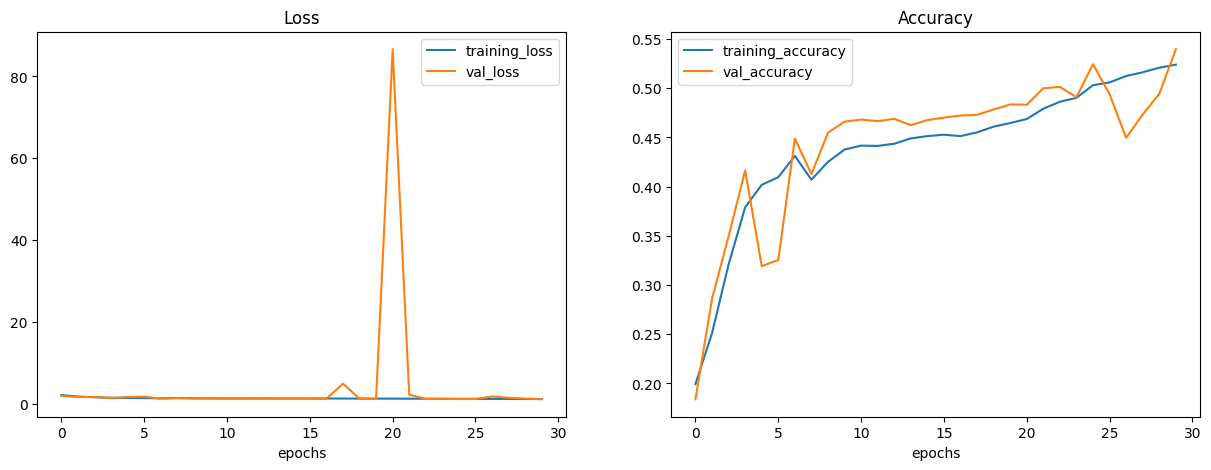

In [16]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.show()

plot_curves(VGG19_history)


113/113 [==============================] - 7s 61ms/step


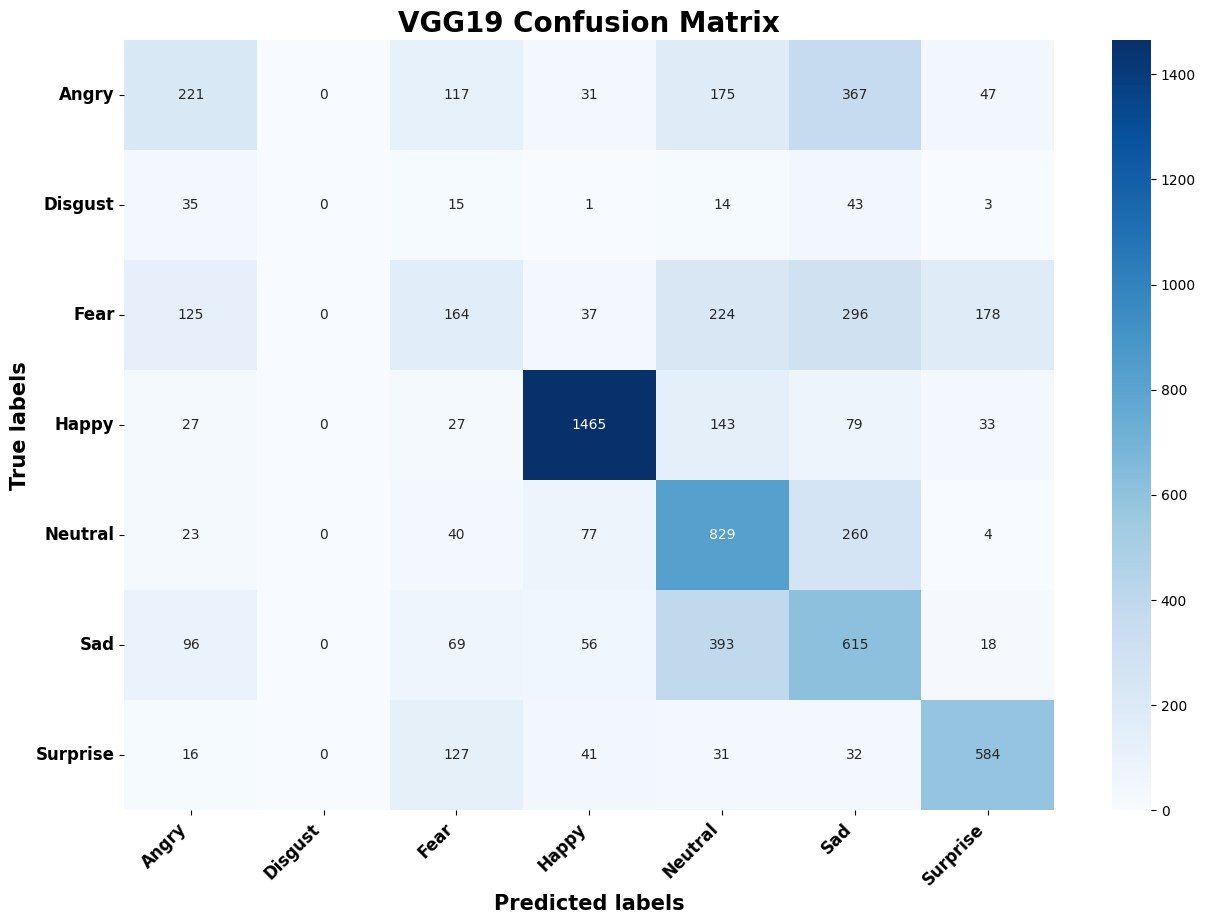

In [17]:
VGG19_Predictions = VGG19_Model.predict(test_data)
VGG19_Predictions = np.argmax(VGG19_Predictions, axis=1)

cm = confusion_matrix(test_data.labels, VGG19_Predictions)

Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('VGG19 Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_yticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_xticklabels(Emotion_Classes, rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(Emotion_Classes, rotation=0, fontsize=12, fontweight='bold')

plt.show()


Found 7178 images belonging to 7 classes.


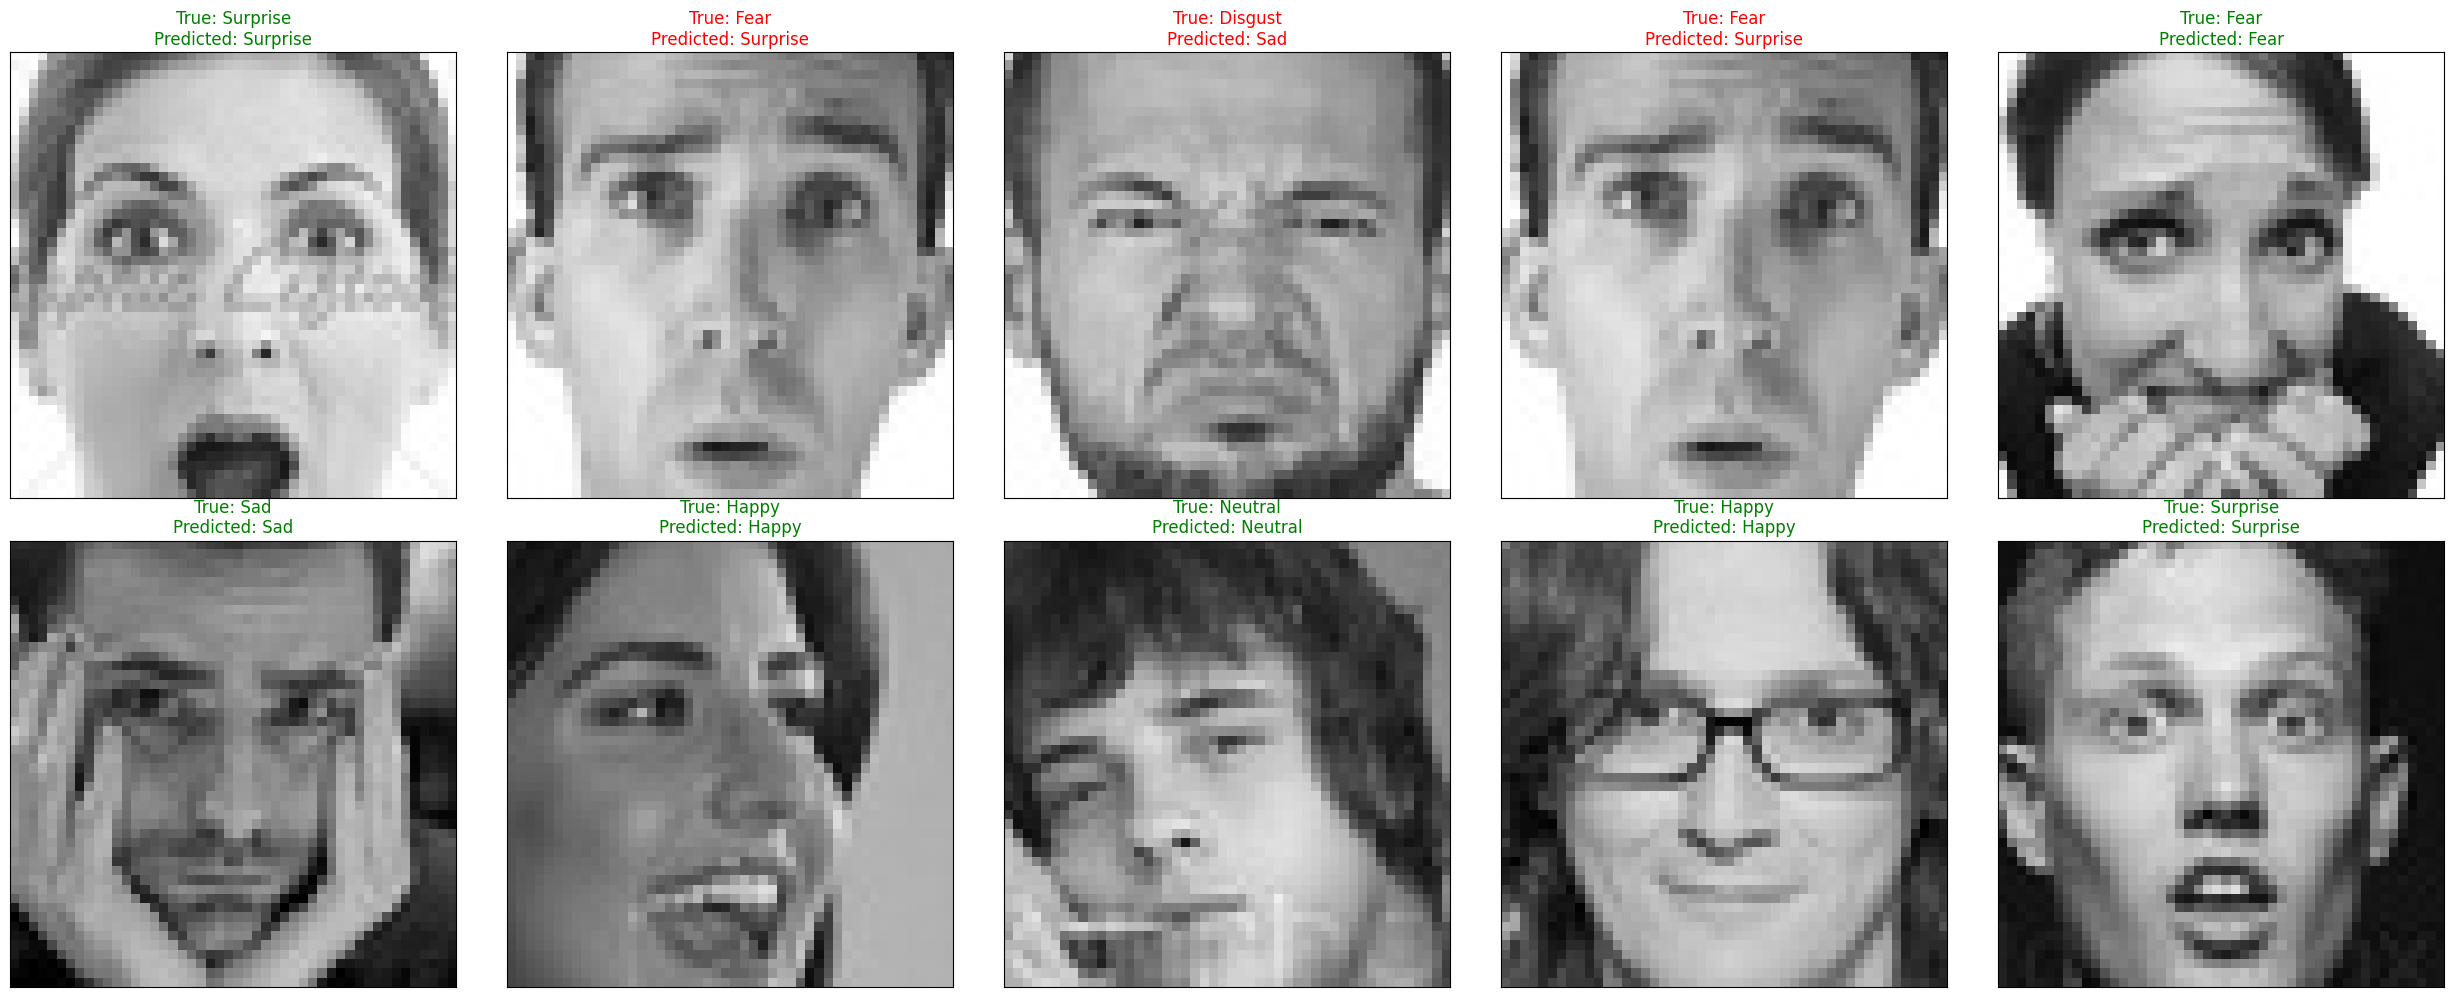

In [20]:
test_preprocessor = ImageDataGenerator(rescale=1/255.)

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(VGG19_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))

    ax.imshow(Random_Img)
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

